In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import git
import pathlib

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)
    
from libs.constants import model_seeds, error_seeds

In [4]:
model_meta_type = "mnist32-cnn"

ERR_PARAM_list = [2,3]
MAX_FAULT_PROB_list = [100E-3, 200E-3, 500E-3]
error_layer_list = ["h2", "op", "h2-op"]
ERR_NAME_LIST = {1:"Flip-to-1",
                -1:"Bitflip",
                 0:"Flip-to-0",
                 2:"TF32",
                 3:"BF16"}

err_tag_list = ["LIM_" + f"{int(MAX_FAULT_PROB*1E3):02d}" for MAX_FAULT_PROB in MAX_FAULT_PROB_list]

In [5]:
results_folder_tag = "c0--LIM_01_02_05-ERR_1_-1"
results_folder = pathlib.Path(PROJ_ROOT_PATH / "notebooks"/ "ga" / model_meta_type /results_folder_tag )
results_filename = 'evaluate_ga_genes-mnist32-cnn--c0--LIM_01_02_05-ERR_1_-1.npy'
results_file = pathlib.Path(results_folder / results_filename )
results = np.load(str(results_file), allow_pickle='TRUE').item()

In [6]:
model_seeds_from_keys = list(results.keys())
error_profiles_from_keys = list(results[model_seeds[0]].keys())[1:]
error_seeds = error_seeds[0:3]

In [7]:
# given err_tag
# for all model seeds
# for all error seeds

In [8]:
fig_values = {}

In [9]:
fig_values["original_accs"] = {}
dummy = []
for model_seed in model_seeds_from_keys:
    dummy.append(results[model_seed]["original_acc"])
fig_values["original_accs"]["avg"] = np.mean(dummy)
fig_values["original_accs"]["std"] = np.std(dummy)

In [10]:
for ERR_PARAM in ERR_PARAM_list:
    fig_values[ERR_PARAM] = {}
    for err_tag in err_tag_list:
        fig_values[ERR_PARAM][err_tag] = {}
        error_profiles_from_err_tag = [err_tag+'-'+str(error_seed) for error_seed in error_seeds]
        for error_layer in error_layer_list:
            fig_values[ERR_PARAM][err_tag][error_layer] = {}
            fig_values[ERR_PARAM][err_tag][error_layer]["faulty"] = {}
            fig_values[ERR_PARAM][err_tag][error_layer]["ga_optim"] = {}
            fig_values[ERR_PARAM][err_tag][error_layer]["recovery"] = {}
            dummy_faulty = []
            dummy_ga_optim = []
            dummy_recovery = []
            for model_seed in model_seeds_from_keys:
                for error_profile_tag in error_profiles_from_err_tag:
                    faulty = results[model_seed][error_profile_tag][ERR_PARAM][error_layer]["faulty"]
                    ga_optim = results[model_seed][error_profile_tag][ERR_PARAM][error_layer]["ga_optim"]
                    recovery = ga_optim - faulty

                    dummy_faulty.append(faulty)
                    dummy_ga_optim.append(ga_optim)
                    dummy_recovery.append(recovery)
                    
            fig_values[ERR_PARAM][err_tag][error_layer]["faulty"]["avg"] = np.mean(dummy_faulty)
            fig_values[ERR_PARAM][err_tag][error_layer]["faulty"]["std"] = np.std(dummy_faulty)

            fig_values[ERR_PARAM][err_tag][error_layer]["ga_optim"]["avg"] = np.mean(dummy_ga_optim)
            fig_values[ERR_PARAM][err_tag][error_layer]["ga_optim"]["std"] = np.std(dummy_ga_optim)

            fig_values[ERR_PARAM][err_tag][error_layer]["recovery"]["avg"] = np.mean(dummy_recovery)
            fig_values[ERR_PARAM][err_tag][error_layer]["recovery"]["std"] = np.std(dummy_recovery)

In [22]:
cm = plt.get_cmap('tab20')
color_dict = {}
counter = 0
for error_layer in error_layer_list:
    color_dict[error_layer] = {}
    for val_type in ["faulty", "recovery"]:
        color_dict[error_layer][val_type] = cm.colors[counter]
        counter += 1

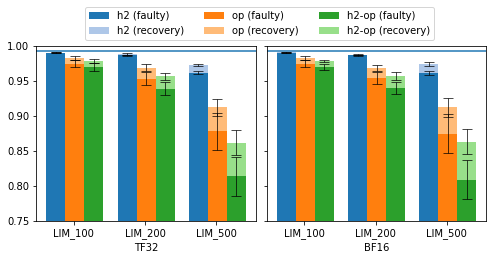

In [57]:
# Plot figure
fig_width = 3.125/0.8 * 2
fig_height = fig_width / 1.618 /1.5
n_rows = 1
n_cols = len(ERR_PARAM_list)
fig, axs = plt.subplots(nrows=n_rows,
                        ncols=n_cols,
                        figsize=[fig_width,fig_height], # in inches
                        sharex=True,
                        sharey=True,
                        constrained_layout=False, 
                        # tight_layout=True
                       )
plt.subplots_adjust(left=0.1, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

for idx, ERR_PARAM in enumerate(ERR_PARAM_list):
    # Each subplot is for one type of error 
    ax = axs[idx]
    ax.set_ylim(0.75,1.0)
    # Print type of error
    text = ERR_NAME_LIST[ERR_PARAM]
    # ax.text(0.5, 0.25, 
    #        text, 
    #        horizontalalignment='center', 
    #        verticalalignment='center', 
    #        transform=ax.transAxes)
    
    
    ax.set_xticks([0.25,1.25,2.25],err_tag_list)   
    ax.set_xlabel( ERR_NAME_LIST[ERR_PARAM])
    
    # Plot original accuracy line
    ax.axhline(y=fig_values["original_accs"]["avg"])
    ax.axhspan(fig_values["original_accs"]["avg"] - fig_values["original_accs"]["std"], 
               fig_values["original_accs"]["avg"] + fig_values["original_accs"]["std"], alpha=0.5)

    # Plot faulty + recovery
    for erridx, error_layer in enumerate(error_layer_list):
        y_offsets = np.array([0]*len(err_tag_list))
        for val_type in ["faulty", "recovery"]:
            layer_avgs = [fig_values[ERR_PARAM][err_tag][error_layer][val_type]["avg"] for err_tag in err_tag_list]
            layer_stds = [fig_values[ERR_PARAM][err_tag][error_layer][val_type]["std"] for err_tag in err_tag_list]
            # if val_type == "faulty":
            #     layer_stds = [fig_values[ERR_PARAM][err_tag][error_layer][val_type]["std"] for err_tag in err_tag_list]
            # else:
            #     layer_stds = [0 for err_tag in err_tag_list]

            x_roots = np.arange(len(MAX_FAULT_PROB_list))
            width = 0.8
            bar_width = width/len(error_layer_list)
            x_offsets = erridx * bar_width
            x_poss = x_roots + x_offsets
            ax.bar(x_poss,
                  layer_avgs,
                   width=bar_width,
                   bottom=y_offsets,
                   yerr=layer_stds,
                   label=error_layer+' ('+val_type+')',
                   color=color_dict[error_layer][val_type],
                  error_kw=dict(ecolor='black', lw=1, capsize=5, capthick=1, alpha=0.7))
            y_offsets = layer_avgs

axs[0].legend(ncol=3,
          bbox_to_anchor=(0.2, 1.25, 0, 0.),
          loc='upper left')